In [1]:
import os
import pickle
import random
import glob
import datetime
import pandas as pd
import numpy as np
import cv2
import pydicom
from tqdm import tqdm
from joblib import delayed, Parallel
import zipfile
from pydicom.filebase import DicomBytesIO
import sys
from PIL import Image
import cv2
#from focal_loss import sparse_categorical_focal_loss
import keras
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3

# importing pyplot and image from matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
from keras.optimizers import SGD
from keras import backend
from keras.models import load_model

from keras.preprocessing import image
import albumentations as A


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from tensorflow.keras.losses import Reduction

from tensorflow_addons.losses import SigmoidFocalCrossEntropy

In [3]:
base_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train/'
TEST_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_test/'
image_dir = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/png/train/adjacent-brain-cropped/'
save_dir = 'home/ubuntu/kaggle/models/'
os.listdir(base_url)

def png(image): 
    return image + '.png'

# learning rate

In [4]:
initial_learning_rate = 1e-2
first_decay_steps = 1000
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      initial_learning_rate,
      first_decay_steps))
opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, nesterov=True)

# Generator

In [5]:
train_idg = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        shear_range=0.05,
        rotation_range=50, # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,
        rescale=1./255)
valid_idg = ImageDataGenerator(rescale=1./255)
training_data = pd.read_csv(f'train_0.csv') 
training_data['Image'] = training_data['Image'].apply(png)

validation_data = pd.read_csv(f'valid_0.csv')
validation_data['Image'] = validation_data['Image'].apply(png)

columns=['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']

#train_data_generator = train_idg.flow_from_dataframe(training_data, directory = image_dir,
#                           x_col = "Image", y_col = columns,batch_size=64,
#                           class_mode="raw", target_size=(224,224), shuffle = True)
#valid_data_generator  = valid_idg.flow_from_dataframe(validation_data, directory = image_dir,
#                        x_col = "Image", y_col = columns,batch_size=64,
#                        class_mode = "raw",target_size=(224,224), shuffle = False)

In [40]:
train_under_generator = train_idg.flow_from_dataframe(l, directory = image_dir,
                           x_col = "Image", y_col = columns,batch_size=64,
                           class_mode="raw", target_size=(224,224), shuffle = True)
valid_under_generator  = valid_idg.flow_from_dataframe(m, directory = image_dir,
                        x_col = "Image", y_col = columns,batch_size=64,
                        class_mode = "raw",target_size=(224,224), shuffle = False)

Found 257598 validated image filenames.
Found 64320 validated image filenames.


# Undersamping

In [7]:
def undersample(dataframe,steps,batch_size):
        part = np.int(steps/3 * batch_size)
        zero_ids = np.random.choice(dataframe.loc[dataframe["any"] == 0].index.values, size=2*part, replace=False)
        hot_ids = np.random.choice(dataframe.loc[dataframe["any"] == 1].index.values, size=1*part, replace=False)
        data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(data_ids)
        return data_ids
        

In [8]:
train_indices = undersample(training_data, 8050,32)
print(len(train_indices))

257598


In [9]:
valid_indices = undersample(validation_data, 2010,32)
print(len(valid_indices))

64320


In [10]:
l = training_data[training_data.index.isin(train_indices)]
m = validation_data[validation_data.index.isin(valid_indices)]

# Model

In [23]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model.layers[:28]:
    layer.trainable = False

In [34]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
      
]


# create the base pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
print('Model loaded.')



# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)
net = Dense(256, activation='elu')(x)
net = Dense(6, activation='sigmoid')(net)


# this is the model we will train
model = Model(inputs=base_model.input, outputs=net)



# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False
for layer in base_model.layers[:28]:
    layer.trainable = False


# compile the model (should be done *after* setting layers to non-trainable)
model.compile(opt, loss='binary_crossentropy', metrics=METRICS)




model.summary()

Model loaded.
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_________________________________________________________________________

# Callback

In [35]:
from keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/models/mobilenetv2_{epoch:08d}.h5', period=1,mode= 'auto',save_best_only=True) 

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callback_list = [checkpoint]


In [36]:
tf.config.experimental_run_functions_eagerly(True)

In [37]:
class_weight = {0:1.0,1:2.0}
class_weight

{0: 1.0, 1: 2.0}

In [41]:



num_epochs = 20

batch_size = 512
training_steps = len(training_data) // batch_size
validation_step = len(validation_data) // batch_size





# FIT THE MODEL
history = model.fit(train_under_generator,
            epochs=num_epochs,
            steps_per_epoch=training_steps,
            callbacks=callback_list,
            class_weight=class_weight,
            validation_data=valid_under_generator,
            validation_steps= validation_step
                   ) 





tf.keras.backend.clear_session()


Epoch 1/20
1173/1173 [==============================] - 1328s 1s/step - loss: 0.2700 - tp: 19402.0000 - fp: 8747.0000 - tn: 382086.0000 - fn: 40185.0000 - accuracy: 0.8914 - precision: 0.6893 - recall: 0.3256 - auc: 0.8689 - val_loss: 0.2460 - val_tp: 5447.0000 - val_fp: 1729.0000 - val_tn: 96812.0000 - val_fn: 9676.0000 - val_accuracy: 0.8997 - val_precision: 0.7591 - val_recall: 0.3602 - val_auc: 0.8964
Epoch 2/20
1173/1173 [==============================] - 1296s 1s/step - loss: 0.2220 - tp: 29348.0000 - fp: 9754.0000 - tn: 380669.0000 - fn: 30661.0000 - accuracy: 0.9103 - precision: 0.7505 - recall: 0.4891 - auc: 0.9167 - val_loss: 0.2277 - val_tp: 5878.0000 - val_fp: 1266.0000 - val_tn: 97275.0000 - val_fn: 9245.0000 - val_accuracy: 0.9075 - val_precision: 0.8228 - val_recall: 0.3887 - val_auc: 0.9169
Epoch 3/20
1173/1173 [==============================] - 1292s 1s/step - loss: 0.2078 - tp: 31038.0000 - fp: 9584.0000 - tn: 381852.0000 - fn: 27958.0000 - accuracy: 0.9167 - precisio

# Evalution

In [42]:
valid_predict =  model.evaluate_generator(valid_under_generator)
print(valid_predict)

Instructions for updating:
Please use Model.evaluate, which supports generators.
[0.1724531054496765, 29916.0, 3813.0, 331362.0, 20829.0, 0.9361472129821777, 0.8869518637657166, 0.5895358920097351, 0.9536344408988953]


In [43]:
model.metrics_names

['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc']

In [44]:
print('\n---------------\n')
print('validation data **loss** value =', valid_predict[0])
print('\n---------------\n')
print('validation data **true positive** value = ', valid_predict[1])
print('\n---------------\n')
print('validation data **false positive** value =', valid_predict[2])
print('\n---------------\n')
print('validation data **true negative** value =', valid_predict[3])
print('\n---------------\n')
print('validation data **false negative** value =', valid_predict[4])
print('\n---------------\n')
print('validation data **accuracy** value = ', valid_predict[5])
print('\n---------------\n')
print('validation data **precision** value =', valid_predict[6])
print('\n---------------\n')
print('validation data **recall* value =', valid_predict[7])
print('\n---------------\n')
print('validation data **AUC* value =', valid_predict[8])
print('\n---------------\n')


---------------

validation data **loss** value = 0.1724531054496765

---------------

validation data **true positive** value =  29916.0

---------------

validation data **false positive** value = 3813.0

---------------

validation data **true negative** value = 331362.0

---------------

validation data **false negative** value = 20829.0

---------------

validation data **accuracy** value =  0.9361472129821777

---------------

validation data **precision** value = 0.8869518637657166

---------------

validation data **recall* value = 0.5895358920097351

---------------

validation data **AUC* value = 0.9536344408988953

---------------



In [65]:
y_true = m[['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']].reset_index(drop=True)

Y_pred = model.predict_generator(valid_under_generator)
preds = np.where(Y_pred < 0.25, 0, 1)



#val = 0.25

#Y_pred[Y_pred>=val]=1
#Y_pred[Y_pred<val]=0

# Classifcation Report

In [66]:
print('Classification Report')
target_names = ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
print(classification_report(y_true, preds, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

             any       0.88      0.81      0.84     21440
        epidural       0.09      0.02      0.04       571
intraparenchymal       0.73      0.79      0.76      6890
intraventricular       0.72      0.80      0.76      5123
    subarachnoid       0.65      0.56      0.61      7218
        subdural       0.73      0.56      0.63      9503

       micro avg       0.78      0.72      0.75     50745
       macro avg       0.63      0.59      0.61     50745
    weighted avg       0.77      0.72      0.74     50745
     samples avg       0.24      0.24      0.23     50745



/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


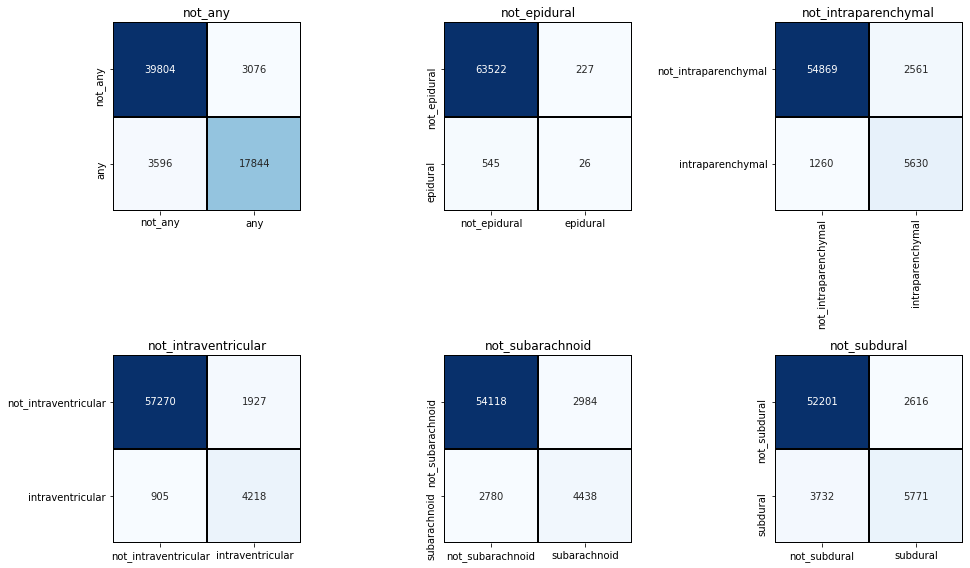

In [63]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
# Creating multilabel confusion matrix
confusion = multilabel_confusion_matrix(y_true, preds)
mlb= ['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']
# Plot confusion matrix 
fig = plt.figure(figsize = (14, 8))
for i, (label, matrix) in enumerate(zip(mlb, confusion)):
    plt.subplot(f'23{i+1}')
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()

# AUC_ROC_SCORE

In [64]:
auc = roc_auc_score(y_true, preds)
print(auc)

0.7906662051891526


# ACCURACY AND LOSS PLOT

In [50]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    with plt.xkcd():
        plt.figure(figsize = (10,10))
        plt.plot(H.epoch,H.history["accuracy"], label="train_acc")
        plt.plot(H.epoch,H.history["val_accuracy"], label="val_acc")
        plt.title("Training Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower left")
        plt.show()

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


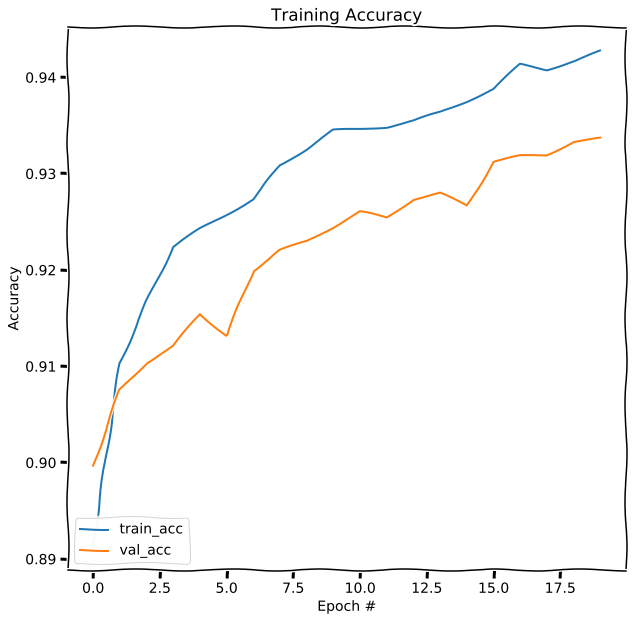

In [51]:
plot_training(history)

In [52]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    with plt.xkcd():
        plt.figure(figsize = (10,10))
        plt.plot(H.epoch,H.history["loss"], label="train_loss")
        plt.plot(H.epoch,H.history["val_loss"], label="val_loss")
        plt.title("Training Loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend(loc="lower left")
        plt.show()

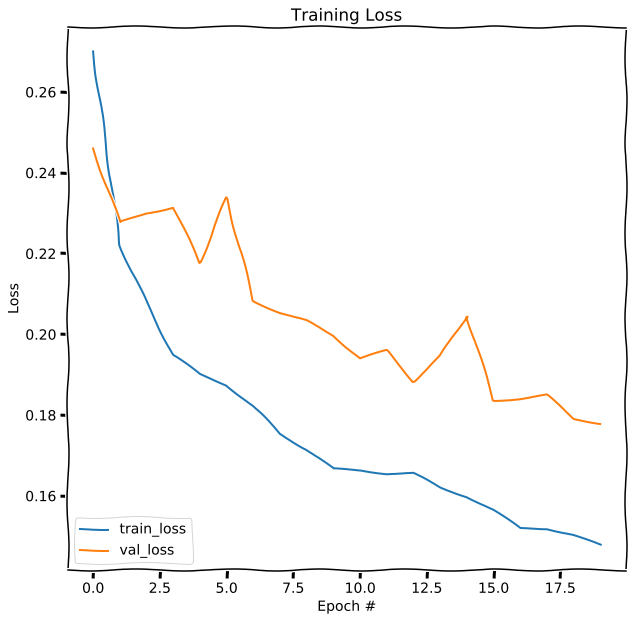

In [53]:
plot_training(history)